### Исследование таблицы БАДы

In [1]:
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("./data/new_vitamins.xlsx", sheet_name="БАДы")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID продукта                 1960 non-null   object
 1   Название                    1960 non-null   object
 2   Список ингридиентов         1955 non-null   object
 3   Рекомендации по применению  1960 non-null   object
 4   Продолжительность приема    1960 non-null   object
 5   Примечание                  1960 non-null   object
 6   Противопоказания            1960 non-null   object
dtypes: object(7)
memory usage: 107.3+ KB


In [4]:
df.sample(3)

,ID продукта,Название,Список ингридиентов,Рекомендации по применению,Продолжительность приема,Примечание,Противопоказания
1956,B0000001957,Блок Декстроза Энергия Витал,V000000001,-,-,-,-
1616,B0000001617,Бессмертника песчаного цветки,V000000404,"1 фильтр-пакет (1,5-2 г) залить 1 стаканом (20...",Продолжительность приема - 1 месяц.,-,"индивидуальная непереносимость компонентов, бе..."
1058,B0000001059,Аргинин,V000000022,"Взрослым принимать по 5 капсул, или по 3 табле...",Продолжительность приема - 1 месяц.,При необходимости прием можно повторить.,"индивидуальная непереносимость компонентов, бе..."


Всего собрана информация по 1960 БАДам, но, видно, что для 3 строк отсутвует список ингредиентов, что не очень подходит для задачи.

Столбцы "Рекомендации по применению", "Продолжительность приема", "Примечание" были получены на предыдущем шаге (ноутбук supplements normalization.ipynb) из одного столбца.

Для лучшего понимания данных будет интересно исследовать признаки "Список ингридиентов", "Рекомендации по применению", "Продолжительность приема", "Примечание", "Противопоказания"

#### Список ингридиентов

In [5]:
df["Список ингридиентов"].value_counts()

Список ингридиентов
V000000001                                                                                        623
V000000013                                                                                         51
V000000404                                                                                         31
V000000025                                                                                         18
V000000022                                                                                         15
                                                                                                 ... 
V000000114                                                                                          1
V000000013, V000000017, V000000052, V000000446, V000000361, V000000393, V000000295                  1
V000000168, V000000393, V000000295                                                                  1
V000000013, V000000005, V000000010, V000000017, V000000361, V0

Такая частота встречаемости значений не очень полезна, т.к. всего 917 уникальных строк. Однако, сразу видно, что компонент V000000001 (ингредиент не определен) встречается 623 раза. Для этих строк также отсутствуют противопоказания и правила приема. Их можно удалить из исследования.

Информация по этим БАДам собирается и дополняется  - ищутся сайты с доступом.

In [6]:
df = df[df["Список ингридиентов"] != "V000000001"].dropna()

df.shape

(1332, 7)

1334 БАДов с определенными ингредиентами

Посмотрим, какое количество компонентов содержится в БАДах

In [7]:
df["num_ingrs"] = df["Список ингридиентов"].progress_apply(lambda x: len(x.split(", ")))

100%|██████████| 1332/1332 [00:00<00:00, 462906.03it/s]


In [8]:
data = df["num_ingrs"].value_counts().reset_index()

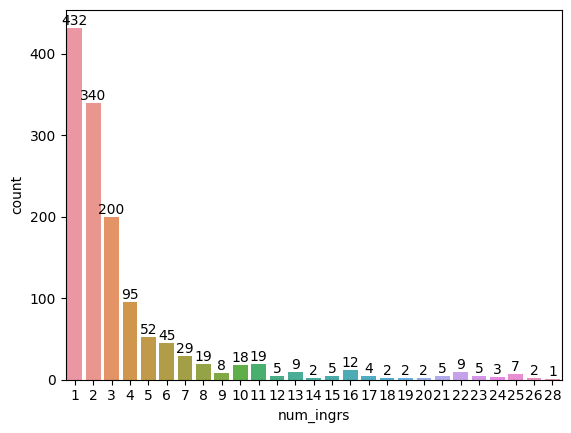

In [9]:
ax = sns.barplot(data, x="num_ingrs", y="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10);

432, 340, 200 БАДа содержат 1б 2 и 3 компонента соответственно. С увеличением количества ингредиентов, количество БАДов в выборке снижается.  Самое большое количество ингредиентов в БАДе - 28. 


Посмотрим на частотность вхождения ингредиентов в БАДы

In [10]:
ingrs = set(
    [
        ingr
        for ingr_str in df["Список ингридиентов"].unique()
        for ingr in ingr_str.split(", ")
    ]
)

In [11]:
result = {}
for ingr in ingrs:
    count = df["Список ингридиентов"].str.contains(ingr).sum()
    result[ingr] = count

In [12]:
result.pop("")

1332

In [13]:
df_ingrs = (
    pd.DataFrame({"ingredients": result.keys(), "counts": result.values()})
    .sort_values(by="counts", ascending=False)
    .reset_index(drop=True)
)

In [14]:
df_ingrs.shape

(374, 2)

In [15]:
df_ingrs

,ingredients,counts
0,V000000013,316
1,V000000017,211
2,V000000404,194
3,V000000010,170
4,V000000446,152
...,...,...
369,V000000085,1
370,V000000115,1
371,V000000091,1
372,V000000454,1


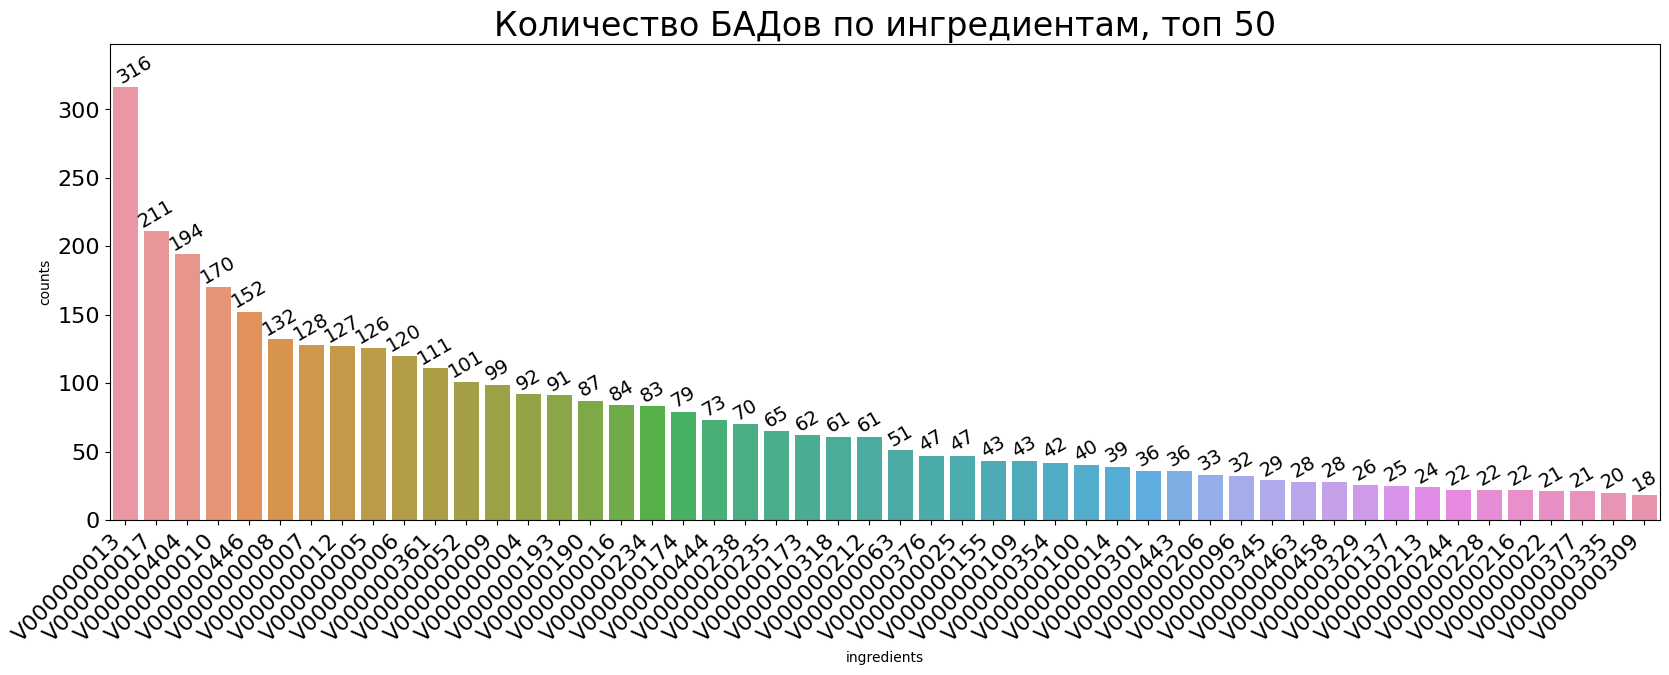

In [16]:
df_ingrs50 = df_ingrs.head(50)
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.barplot(x=df_ingrs50["ingredients"], y=df_ingrs50["counts"], ax=ax)
for i in range(len(df_ingrs50)):
    if i == 0:
        d = i + 0.3
    else:
        d = i
    ax.text(
        d,
        df_ingrs50.loc[i, "counts"] + df_ingrs50["counts"].max() / 100,
        df_ingrs50.loc[i, "counts"],
        color="black",
        ha="center",
        fontsize=14,
        rotation=30,
    )
fig.autofmt_xdate(rotation=45)
ax.set_title("Количество БАДов по ингредиентам, топ 50", fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, df_ingrs50.loc[0, "counts"] * 1.1)
plt.show()

Для лучшего понимания данных надо приконкатить названия витаминов.

In [17]:
df_i = pd.read_excel("./data/new_vitamins.xlsx")

In [18]:
df_i = df_i[['ID ингридиента БАДа',	'Название ингридиента БАДа']]

In [19]:
df_i.shape

(375, 2)

In [20]:
df_ingrs = df_ingrs.set_index("ingredients").join(
    df_i.set_index("ID ингридиента БАДа"),
    how='left'
)

In [21]:
df_ingrs = df_ingrs.reset_index()

In [22]:
df_ingrs.head()

,ingredients,counts,Название ингридиента БАДа
0,V000000013,316,C
1,V000000017,211,E
2,V000000404,194,флавоноиды
3,V000000010,170,B6
4,V000000446,152,цинк


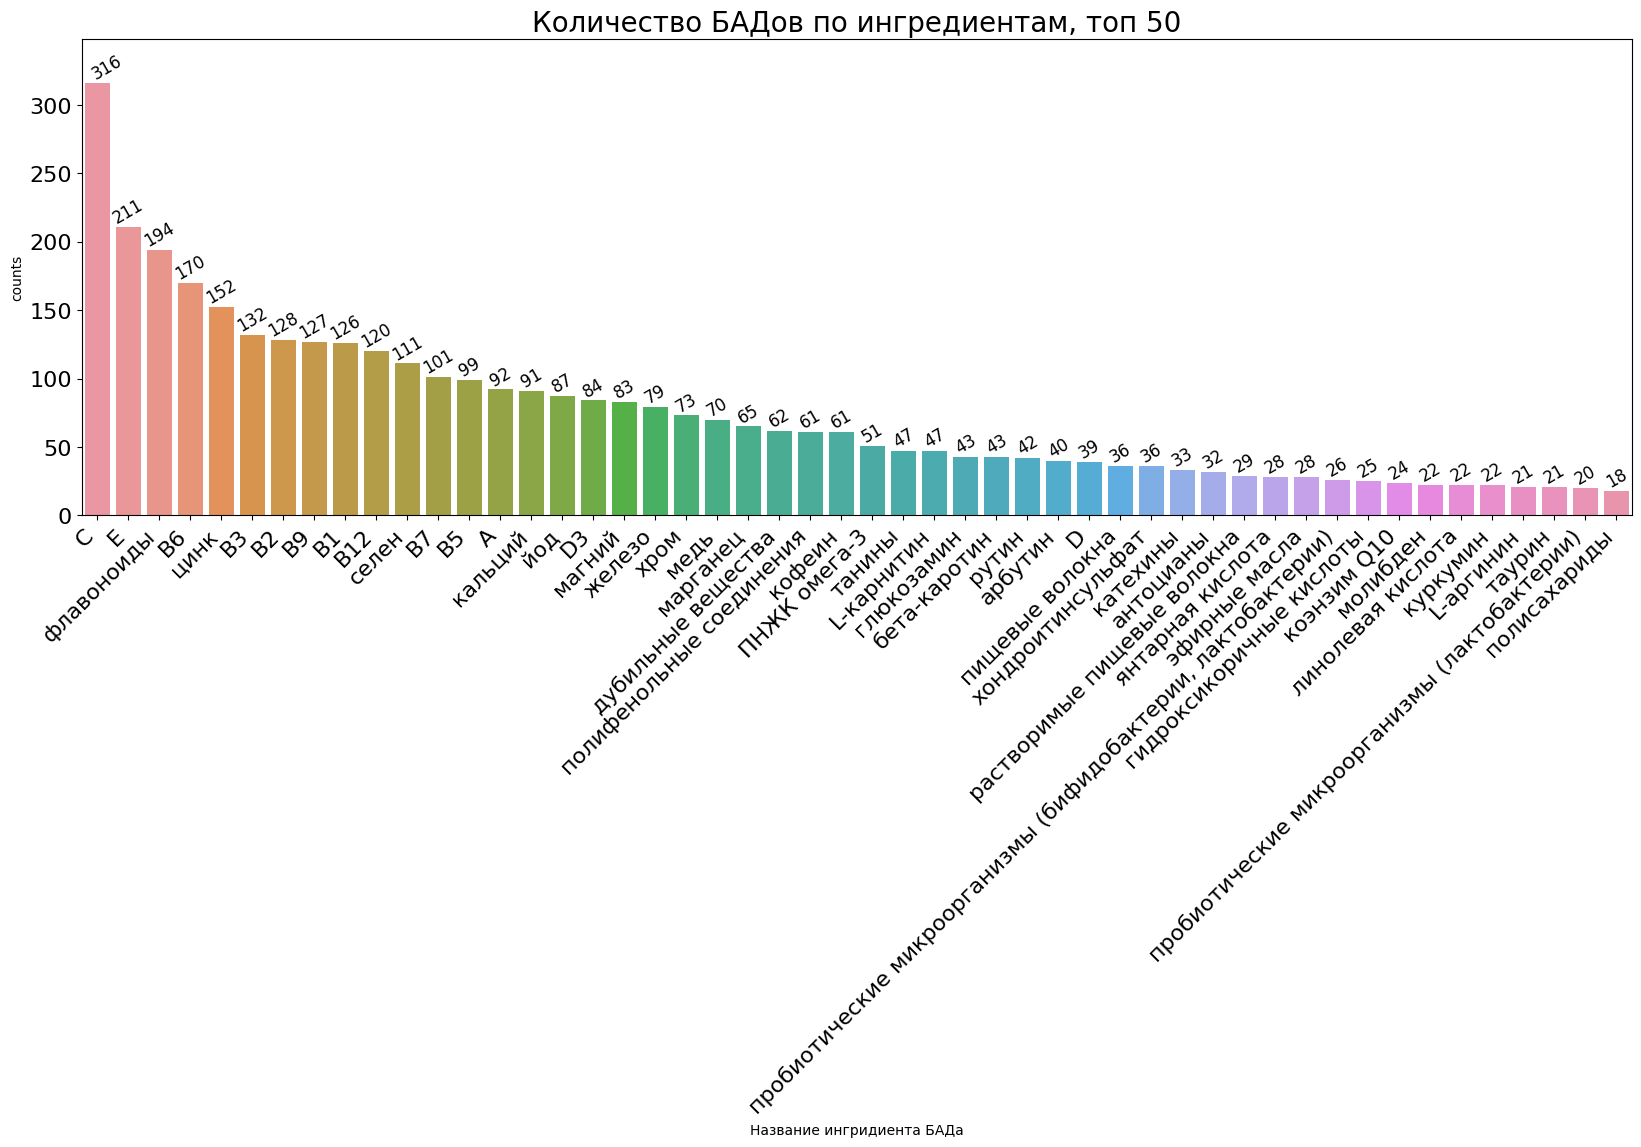

In [23]:
df_ingrs50 = df_ingrs.head(50)
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.barplot(
    y=df_ingrs50["counts"], x=df_ingrs50["Название ингридиента БАДа"], ax=ax
)
for i in range(len(df_ingrs50)):
    if i == 0:
        d = i + 0.3
    else:
        d = i
    ax.text(
        d,
        df_ingrs50.loc[i, "counts"] + df_ingrs50["counts"].max() / 100,
        df_ingrs50.loc[i, "counts"],
        color="black",
        ha="center",
        fontsize=12,
        rotation=30,
    )
fig.autofmt_xdate(rotation=45)
ax.set_title("Количество БАДов по ингредиентам, топ 50", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, df_ingrs50.loc[0, "counts"] * 1.1)
plt.show()

In [24]:
df_ingrs[df_ingrs['counts'] == 1].shape[0]

137

Самые часто встречающиеся в БАДах ингредиенты - витамины С и Е. 137 витаминов встречаются в БАД по 1 разу.

### Рекомендации по применению

In [25]:
df["Рекомендации по применению"].nunique()

778

In [26]:
df["Рекомендации по применению"].value_counts()

Рекомендации по применению
Взрослым по 1 капсуле в день во время еды.                                                                                          73
Взрослым по 1 капсуле 2 раза в день во время еды.                                                                                   53
Взрослым по 1 таблетке в день во время еды.                                                                                         39
-                                                                                                                                   36
Взрослым по 1 капсуле 3 раза в день во время еды.                                                                                   34
                                                                                                                                    ..
Взрослым по 1 таблетке каждого вида 1 раз в день во время еды.                                                                       1
Детям 3-7 лет по 1 таблетке 

Для 1332 БАДов написано 782 инструкции, самая частотная из которых "Взрослым по 1 капсуле в день во время еды."

В инструкциях упоминаются количество приемов, формы приема (таблетка, пакет, капсула и т.п.). Более подробно эти данные исследован при нормализации в ноутбуке supplements normalization.ipynb

При дальнейшей обработке данных возможно также выделение возрастных категорий и особых рекомендаций по употреблению.

### Продолжительность приема 

In [27]:
df["Продолжительность приема"].nunique()

101

In [28]:
df["Продолжительность приема"].value_counts()

Продолжительность приема
Продолжительность приема - 1 месяц.                643
-                                                  201
Продолжительность приема - 3-4 недели.              55
Продолжительность приема - 4-6 недель.              53
Продолжительность приема - 2-3 недели.              50
                                                  ... 
Продолжительность приема - не более 4-х недели.      1
Продолжительность приема - 10-20 дн.                 1
Продолжительность приема - не более 2 недель.        1
Продолжительность приема - 3-5 дней.                 1
Продолжительность приема - 2-3 месяца.               1
Name: count, Length: 101, dtype: int64

In [29]:
data = df["Продолжительность приема"].value_counts().reset_index()

In [30]:
data

,Продолжительность приема,count
0,Продолжительность приема - 1 месяц.,643
1,-,201
2,Продолжительность приема - 3-4 недели.,55
3,Продолжительность приема - 4-6 недель.,53
4,Продолжительность приема - 2-3 недели.,50
...,...,...
96,Продолжительность приема - не более 4-х недели.,1
97,Продолжительность приема - 10-20 дн.,1
98,Продолжительность приема - не более 2 недель.,1
99,Продолжительность приема - 3-5 дней.,1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Продолжительность приема - 1 месяц.'),
  Text(1, 0, '-'),
  Text(2, 0, 'Продолжительность приема - 3-4 недели.'),
  Text(3, 0, 'Продолжительность приема - 4-6 недель.'),
  Text(4, 0, 'Продолжительность приема - 2-3 недели.'),
  Text(5, 0, 'Продолжительность приема - 4 недели.'),
  Text(6, 0, 'Продолжительность приема - 2 недели.'),
  Text(7, 0, 'Продолжительность приема - 30 дней.'),
  Text(8, 0, 'Продолжительность приема - 1-2 месяца.'),
  Text(9, 0, 'Продолжительность приема - 20 дней.')])

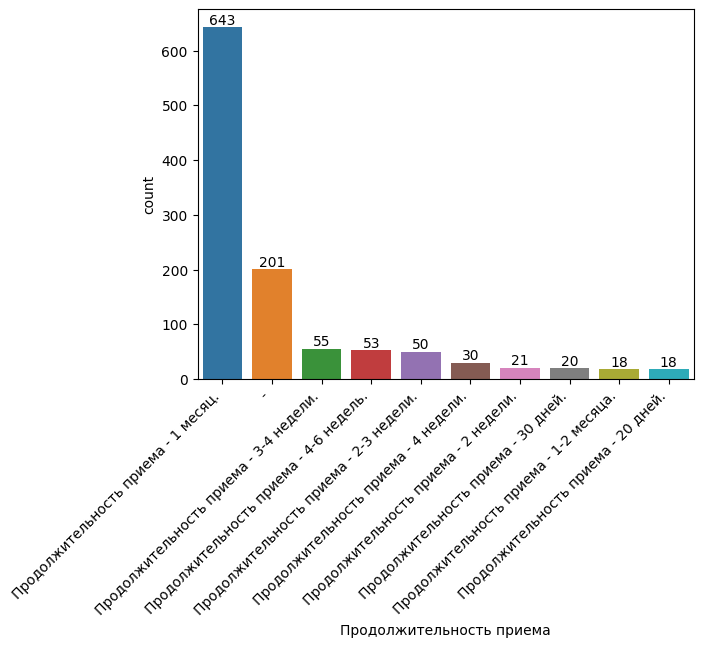

In [31]:
ax = sns.barplot(data.head(10), x="Продолжительность приема", y="count", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xticks(rotation=45, ha="right")

Самые частотны рекомендации по приему - прием от 1 до 2 месяцев. Для 201 БАДа рекомендаций по приему нет.

### Противопоказания

In [32]:
df["Противопоказания"].nunique()

346

In [33]:
df["Противопоказания"].value_counts()

Противопоказания
индивидуальная непереносимость компонентов, беременность, кормление грудью.                                                                                                                                                                                                                                                                                        517
индивидуальная непереносимость компонентов продукта, беременность, кормление грудью.                                                                                                                                                                                                                                                                                89
индивидуальная непереносимость компонентов.                                                                                                                                                                                                                              

In [34]:
pros = set(
    [pro for pro_str in df["Противопоказания"].unique() for pro in pro_str.split(", ")]
)

In [35]:
pros

{'-',
 'Аддисона болезнь',
 'Индивидуальная непереносимость компонентов',
 'а также вместе с алкоголем.',
 'аллергические заболевания',
 'аллергические реакции на продукты пчеловодства',
 'аллергические реакции на продукты пчеловодства.',
 'аллергия на продукты пчеловодства.',
 'артериальная гипертензия',
 'артериальная гипертензия.',
 'артериальная гипертония',
 'артериальная гипо-/гипертензия',
 'атеросклероз',
 'атеросклероз.',
 'беременность',
 'беременность и кормление грудью',
 'беременность и кормление грудью.',
 'беременность и кормление грудью. Лицам',
 'беременность и кормление грудью. Перед применением рекомендуется проконсультироваться с врачом.',
 'беременность и кормление грудью. Перед применением рекомендуется проконсультироваться с врачом. Содержит подсластитель. При чрезмерном употреблении может оказывать слабительное действие.',
 'беременность. кормление грудью',
 'беременным и кормящим женщинам',
 'беременным и кормящим женщинам.',
 'бессоница',
 'бессоница. Содержит

В основном противопоказания связаны с непереносимостью компонентов, кормлением грудью, беременностью. Часть относится к конкретным заболеваниям.

!!! Необходимо нормировать и разделить противопоказания

Важным пунктом для исследования может стать несовместимость с лекарственными препаратами. Проверим это и возьмем на контроль данные БАДы.

In [36]:
def get_nodrugs(text):
    return 1 if 'лекарств' in text else 0

In [37]:
df["nodrugs"] = df["Противопоказания"].progress_apply(get_nodrugs)
df["nodrugs1"] = df["Примечание"].progress_apply(get_nodrugs)

100%|██████████| 1332/1332 [00:00<00:00, 620756.99it/s]


In [38]:
nodrugs = df[(df["nodrugs"] == 1) | (df["nodrugs1"] == 1)]
nodrugs.shape[0]

27

27 БАДов не совместимы с лекарствами по инструкции, что очень важно для исследования, проверим, какие это БАДы

In [39]:
nodrugs["Название"].to_list()

['3-Плода',
 "Man's formula Антистресс",
 'Алтай Флора. Весенний ручеек',
 'Алтай Флора. Скороход',
 'Алтай Флора. Удалец',
 'Алтай Флора. Чистый дом',
 'Альпам 7',
 'Амбовит',
 'АНГЕЛИКА ИНОЗИТ серии Женская линия',
 'Арура-Тан №2',
 'Аструм СР Комфорт',
 'Бальзам «Байкальская Афродита»',
 'Бальзам «Бережем суставы»',
 'Бальзам «Виктория» №1',
 'Бальзам «Виктория» №2',
 'Бальзам «Дар тайги Байкала»',
 'Бальзам «Зарядись энергией Байкала» для мужчин',
 'Бальзам КОЛЛАГЕНОЗИН',
 'Бальзам «Мелодия Байкала»',
 'Бальзам «С берегов Байкала»',
 'Бальзам «Таежный»',
 'Бальзам «Тайны Ольхона»',
 'Бальзам Уральский',
 'Бальзам ФИТОГЕРПАЛ',
 'Берегиня',
 'Биобаланс. Формула 2',
 'Биоритм «Антистресс 24 день/ночь»']

In [40]:
nodrugs_ingrs = set(
    [
        ingr
        for ingr_str in nodrugs["Список ингридиентов"].unique()
        for ingr in ingr_str.split(", ")
    ]
)

In [41]:
nodrugs_result = {}
for ingr in nodrugs_ingrs:
    count = nodrugs["Список ингридиентов"].str.contains(ingr).sum()
    nodrugs_result[ingr] = count

In [42]:
nodrugs_result.pop("")

27

In [43]:
df_nodrugs_ingrs = (
    pd.DataFrame(
        {"ingredients": nodrugs_result.keys(), "counts": nodrugs_result.values()}
    )
    .sort_values(by="counts", ascending=False)
    .reset_index(drop=True)
)

In [44]:
df_nodrugs_ingrs = df_nodrugs_ingrs.set_index("ingredients").join(
    df_i.set_index("ID ингридиента БАДа"), how="left"
)

In [45]:
df_nodrugs_ingrs = df_nodrugs_ingrs.reset_index()

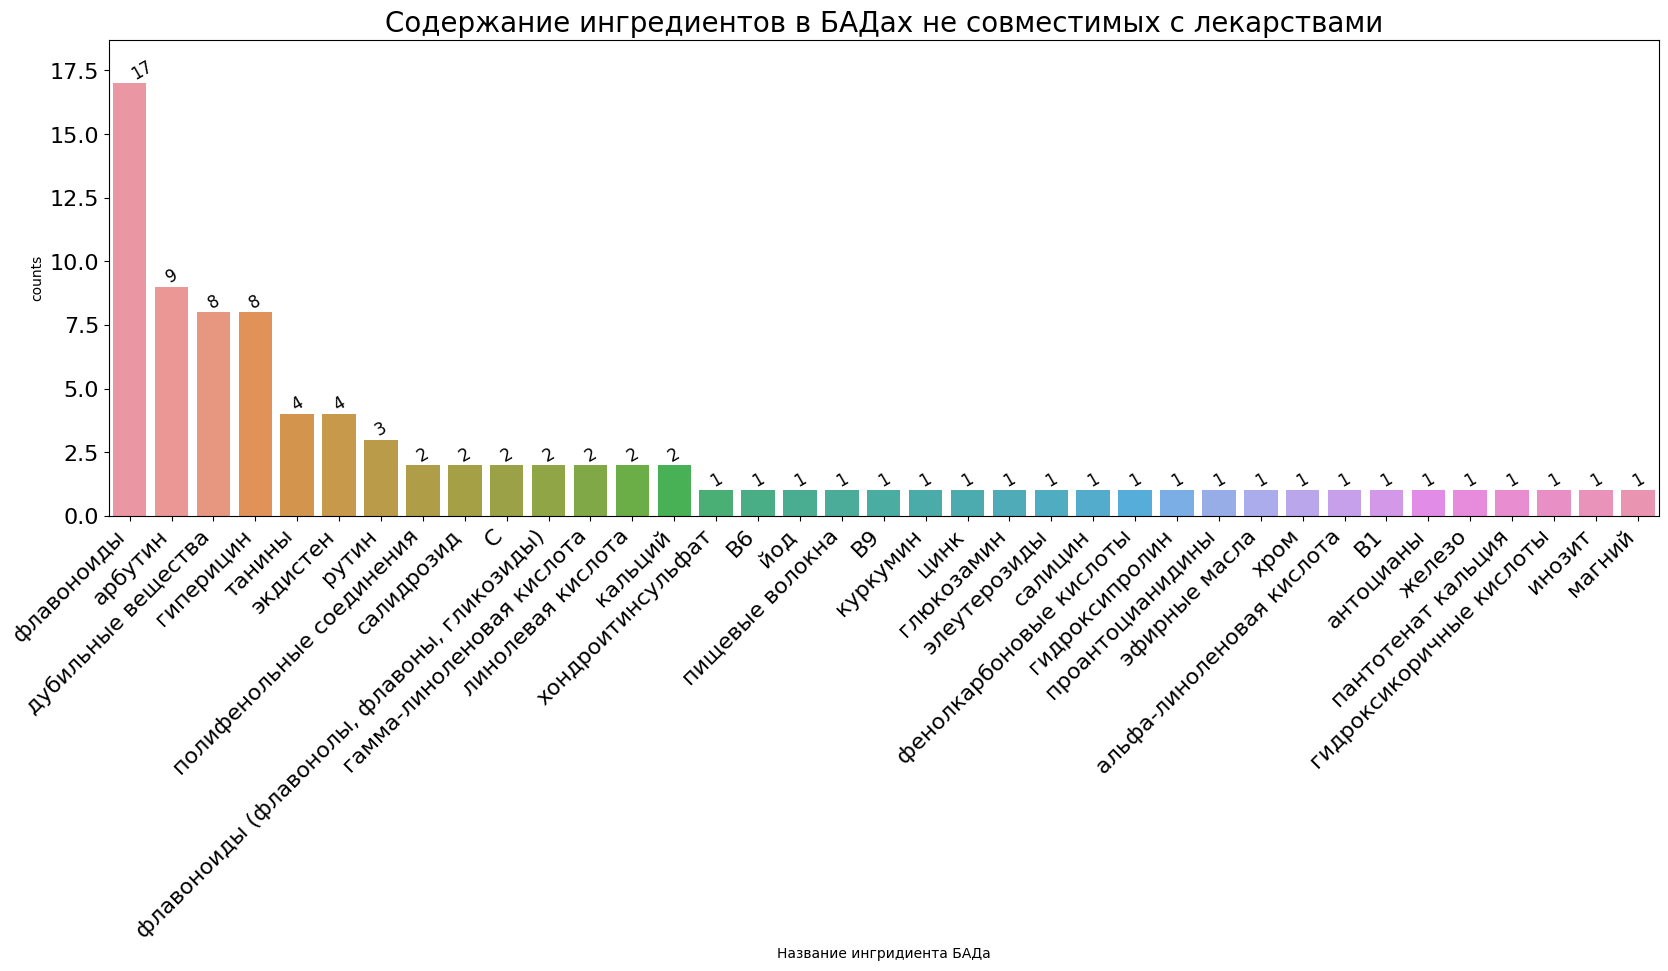

In [46]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = sns.barplot(
    y=df_nodrugs_ingrs["counts"], x=df_nodrugs_ingrs["Название ингридиента БАДа"], ax=ax
)
for i in range(len(df_nodrugs_ingrs)):
    if i == 0:
        d = i + 0.3
    else:
        d = i
    ax.text(
        d,
        df_nodrugs_ingrs.loc[i, "counts"] + df_nodrugs_ingrs["counts"].max() / 100,
        df_nodrugs_ingrs.loc[i, "counts"],
        color="black",
        ha="center",
        fontsize=12,
        rotation=30,
    )
fig.autofmt_xdate(rotation=45)
ax.set_title("Содержание ингредиентов в БАДах не совместимых с лекарствами", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, df_nodrugs_ingrs.loc[0, "counts"] * 1.1)
plt.show()

Видно, что нету общего ингредиента у всех 27 БАДов, но флавоноиды встречается 17 раз (и флавоноиды (флавонолы, флавоны, гликозиды) 2 раза). Этот факт требует контроля и дальнейшего исследования. Возможно, укрупнения группы - объединения видов компонентов.